In [1]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import json
from torch.utils.data import Dataset, DataLoader, Subset
from typing import Dict

import sys
import matplotlib.pyplot as plt
from dataset import Fashion
from torch import nn
import math
import pandas as pd
import torch.nn.functional as F
import wandb
import random
import numpy as np
from PIL import Image, ImageOps
from utils.seed import seed_everything, worker_init_fn
import PIL
import time
from tqdm import tqdm
from torchvision.transforms import v2 as T
from torchvision.transforms import InterpolationMode
import re
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from functools import partial
from torch import Tensor
from typing import Optional
import torchsummary
import pandas as pd
import numpy as np
from torch.profiler import profile, record_function, ProfilerActivity
from torchview import draw_graph
from torch.cuda.amp import GradScaler, autocast
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import gc
import pandas as pd


def free_memory():
    torch.cuda.empty_cache()
    gc.collect()

# torch.autograd.set_detect_anomaly(True)

In [2]:


# model = nn.Linear(128, 128)
# batch_size = 2
# # device='meta' -> no memory is consumed for visualization
# model_graph = draw_graph(model, input_size=(batch_size, 128), device='cuda', expand_nested=True,show_shapes=True)
# display(model_graph.visual_graph)

In [3]:
init_fn = seed_everything(42)

In [4]:
CLASS_TO_INDEX =  {(255, 255, 0): 0, (50, 205, 50): 1, (130, 165, 180): 2, (0, 100, 0): 3, (70, 130, 180): 4, (50, 155, 250): 5, (255, 0, 0): 6, (245, 222, 179): 7, (185, 210, 205): 8, (255, 250, 205): 9, (90, 140, 90): 10, (250, 235, 215): 11, (127, 255, 212): 12}
INDEX_TO_CLASS = {0: (255, 255, 0), 1: (50, 205, 50), 2: (130, 165, 180), 3: (0, 100, 0), 4: (70, 130, 180), 5: (50, 155, 250), 6: (255, 0, 0), 7: (245, 222, 179), 8: (185, 210, 205), 9: (255, 250, 205), 10: (90, 140, 90), 11: (250, 235, 215), 12: (127, 255, 212)}

TRAIN_INPUTS_FOLDER = 'augmented/'
TRAIN_OUTPUTS_FOLDER = 'augmented/'

TEST_INPUTS_FOLDER = 'test_images_preprocessed/'
TEST_OUTPUTS_FOLDER = 'segmentation_processed/'

In [5]:
# Load the CSV file into a DataFrame
# model_structure = pd.read_csv("architectures/HYBRID-M.csv")
# encoder_model_structure = pd.read_csv("architectures/CONV-S.csv")
ENCODER_ARCHITECTURE_FILE_PATH ="architectures/Encoder.csv"
# model_structure = pd.read_csv("architectures/temp.csv")

In [6]:
MAX_IMAGE_SIDE_SIZE = 512
MIN_IMAGE_SIDE_SIZE = 384
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUMBER_OF_EPOCHS = 40000
NUM_WORKERS = 8
PREFETCH_FACTOR = 2
TEMPERATURE=30

NUM_HEADS = 8
NUM_CLASSES = len(INDEX_TO_CLASS)
USE_WANDB = True
GENERAL_NL=nn.ReLU

In [7]:


def adjust_spatial_dimensions(csv_file, input_height, input_width):
    df = pd.read_csv(csv_file)
    current_height = input_height
    current_width = input_width
    df['Width'] = 0  # Initialize the Width column
    for index, row in df.iterrows():
        df.at[index, 'Dim'] = current_height
        df.at[index, 'Width'] = current_width
        if row['Stride'] == 2:
            current_height = max(current_height // 2, 1)
            current_width = max(current_width // 2, 1)
    return df

def create_decoder(encoder_df):
    decoder_layers = []
    encoder_df = encoder_df[::-1]  # Reverse the encoder layers

    # Extract the strides and reverse them, then shift
    strides = encoder_df['Stride'].tolist()[::-1]
    shifted_strides = [strides[i - 1] if i > 0 else 1 for i in range(len(strides))]

    prev_height = encoder_df.iloc[0]['Dim']
    prev_width = encoder_df.iloc[0]['Width']
    prev_block = encoder_df.iloc[0]['Block']

    for index, row in encoder_df.iterrows():
        decoder_layer = row.copy()
        decoder_layer['Channels'], decoder_layer['Output Dim'] = decoder_layer['Output Dim'], decoder_layer['Channels']
        
        stride = shifted_strides[index]
        if prev_block == 'ConvTranspose2D':
            decoder_layer['Dim'] = prev_height * 2
            decoder_layer['Width'] = prev_width * 2
        else:
            decoder_layer['Dim'] = prev_height
            decoder_layer['Width'] = prev_width
        
        # Set the block type
        if stride == 2:
            decoder_layer['Block'] = 'ConvTranspose2D'
        else:
            decoder_layer['Block'] = row['Block']

        if decoder_layer['Block'] == 'Mobile-MQA':
            decoder_layer['Block'] = 'Conv2D'

        # Adjust channels for skip connections
        if row['Skip Connection'] == 1:
            decoder_layer['Channels'] = encoder_df.iloc[-index-1]['Channels'] + decoder_layer['Channels']
        
        prev_height = decoder_layer['Dim']
        prev_width = decoder_layer['Width']
        prev_block = decoder_layer['Block']
        decoder_layer['Stride'] = stride

        decoder_layers.append(decoder_layer)
    
    decoder_df = pd.DataFrame(decoder_layers)

    # Final layer adjustments
    # decoder_df.at[decoder_df.index[-1], 'Output Dim'] = encoder_df.iloc[0]['Width'] * encoder_df.iloc[0]['Dim'] 
    decoder_df.at[decoder_df.index[-1], 'Output Dim'] = encoder_df.iloc[0]['Dim'] 
    decoder_df.at[decoder_df.index[-1], 'Block'] = 'Conv2DFinal'
    decoder_df.at[decoder_df.index[-1], 'Stride'] = 1
    return decoder_df

def process_encoder_decoder(csv_file, input_height, input_width):
    adjusted_encoder_df = adjust_spatial_dimensions(csv_file, input_height, input_width)
    decoder_df = create_decoder(adjusted_encoder_df)
    return adjusted_encoder_df, decoder_df
    
encoder_df, decoder_df = process_encoder_decoder(ENCODER_ARCHITECTURE_FILE_PATH, MAX_IMAGE_SIDE_SIZE, MIN_IMAGE_SIDE_SIZE)

# Display the DataFrames
display("Adjusted Encoder DataFrame:")
display(encoder_df)
display("\nDecoder DataFrame:")
display(decoder_df)

DYN_CONV_CHANNELS = decoder_df.iloc[-1]['Output Dim']
EMBED_DIMENSION = encoder_df.iloc[-1]['Output Dim']
EXTRACTED_FEAT_WIDTH = encoder_df.iloc[-1]['Width']
EXTRACTED_FEAT_HEIGHT = encoder_df.iloc[-1]['Dim']
print(EXTRACTED_FEAT_HEIGHT, EXTRACTED_FEAT_WIDTH)

'Adjusted Encoder DataFrame:'

,Channels,Dim,Block,DW K1,DW K2,Expanded Dim,Output Dim,Stride,Skip Connection,Width
0,3,512,Conv2D,NaN,3.0,NaN,32,2,1,384
1,32,256,FusedIB,NaN,3.0,32.0,32,2,1,192
2,32,128,FusedIB,NaN,3.0,96.0,64,2,1,96
3,64,64,ExtraDW,5.0,5.0,192.0,96,2,1,48
4,96,32,IB,NaN,3.0,192.0,96,1,1,24
5,96,32,IB,NaN,3.0,192.0,96,1,0,24
6,96,32,IB,NaN,3.0,192.0,96,1,0,24
7,96,32,IB,NaN,5.0,192.0,96,1,0,24
8,96,32,ConvNext,3.0,NaN,384.0,96,1,0,24
9,96,32,ExtraDW,3.0,3.0,576.0,128,2,1,24


'\nDecoder DataFrame:'

,Channels,Dim,Block,DW K1,DW K2,Expanded Dim,Output Dim,Stride,Skip Connection,Width
15,256,16,Conv2DFinal,NaN,1.0,NaN,256,1,0,12
14,256,16,IB,NaN,3.0,512.0,128,1,0,12
13,128,16,IB,NaN,3.0,512.0,128,1,0,12
12,128,16,IB,NaN,5.0,384.0,128,1,0,12
11,128,16,IB,NaN,5.0,512.0,128,1,0,12
10,128,16,ConvTranspose2D,5.0,5.0,512.0,128,2,0,12
9,224,32,ExtraDW,3.0,3.0,576.0,96,1,1,24
8,96,32,ConvNext,3.0,NaN,384.0,96,1,0,24
7,96,32,IB,NaN,5.0,192.0,96,1,0,24
6,96,32,IB,NaN,3.0,192.0,96,1,0,24


16 12


In [8]:
def get_subset(dataset, subset_size):
    """
    Get a subset of the dataset.
    
    Args:
        dataset: The original dataset.
        subset_size: The number of samples in the subset.
    
    Returns:
        A subset of the original dataset.
    """
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    subset_indices = indices[:subset_size]
    return Subset(dataset, subset_indices)

In [9]:
def get_transform(max_size, min_size):
    transforms = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomErasing()
        # T.RandomVerticalFlip(),
        # T.RandomResizedCrop(size=(MAX_IMAGE_SIDE_SIZE, MIN_IMAGE_SIDE_SIZE)),
    ])
    non_geo_transforms = T.Compose([
        # T.RandomAdjustSharpness(sharpness_factor=2),
        # T.RandomAutocontrast(),
        # T.ColorJitter(),
        T.RandomChannelPermutation(),
        
    ])
    resize_transform = T.Resize(size=(max_size, min_size), interpolation=Image.BICUBIC)
    return transforms, non_geo_transforms, resize_transform

def get_dataloaders(train_inputs_folder, train_outputs_folder, test_inputs_folder, test_outputs_folder, 
                    batch_size=8, num_workers=None, prefetch_factor=2, max_image_side_size=512, 
                    min_image_side_size=384, train_subset_size=None, test_subset_size=None):
    train_transforms, train_non_geo_transforms, train_resize_transform = get_transform(max_image_side_size, min_image_side_size)
    test_transforms, test_non_geo_transforms, test_resize_transform = get_transform(max_image_side_size, min_image_side_size)

    train_dataset = Fashion(train_inputs_folder, train_outputs_folder, geo_transforms=None)
    test_dataset = Fashion(test_inputs_folder, test_outputs_folder, geo_transforms=None, resize_transform=test_resize_transform, is_test=True)
    
    if train_subset_size:
        train_dataset = get_subset(train_dataset, train_subset_size)
    if test_subset_size:
        test_dataset = get_subset(test_dataset, test_subset_size)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=True, worker_init_fn=worker_init_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=True, worker_init_fn=worker_init_fn)

    return train_loader, test_loader

In [10]:
train_loader, test_loader= get_dataloaders(TRAIN_INPUTS_FOLDER, TRAIN_OUTPUTS_FOLDER, TEST_INPUTS_FOLDER, TEST_OUTPUTS_FOLDER, BATCH_SIZE, NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR, max_image_side_size=MAX_IMAGE_SIDE_SIZE, min_image_side_size=MIN_IMAGE_SIDE_SIZE)

In [11]:
# import matplotlib.pyplot as plt
# import torchvision.transforms.functional as F

# # Function to visualize image and masks
# def visualize_image_and_masks(image, masks):
#     num_masks = masks.size(0)
#     plt.figure(figsize=(5 * (num_masks + 1), 5))
    
#     # Plot input image
#     plt.subplot(1, num_masks + 1, 1)
#     plt.imshow(F.to_pil_image(image))
#     plt.title('Input Image')
#     plt.axis('off')

#     # Plot each mask
#     for i in range(num_masks):
#         plt.subplot(1, num_masks + 1, i + 2)
#         plt.imshow(masks[i].numpy(), cmap='gray')
#         plt.title(f'Mask {i + 1}')
#         plt.axis('off')

#     plt.show()

# # Get one batch of data
# data_iter = iter(train_loader)
# images, masks = next(data_iter)
# print(images.shape)
# print(masks.shape)

# # Select the first image and its masks
# first_image = images[0]
# first_masks = masks[0]

# # Visualize the first image and its masks
# visualize_image_and_masks(first_image, first_masks)


In [12]:
def count_parameters(model):
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)/(1000000)
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)/(1000000)
    print('trainable: ', pytorch_total_params)
    print('total: ', total)
    return sum(p.numel() for p in model.parameters() if p.requires_grad)/(1000000)

In [13]:
class ConvNormAct(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        kernel_size: int,
        norm: nn.Module = nn.BatchNorm2d,
        activation: nn.Module = GENERAL_NL,
        **kwargs
    ):
        super(ConvNormAct, self).__init__()
        if 'padding' not in kwargs:
            kwargs['padding'] = (kernel_size - 1) // 2

        if isinstance(activation, (nn.ReLU, nn.ReLU6, nn.LeakyReLU)):
            activation = activation(inplace=True)
        else: 
            activation = activation()

        # if in_features > out_features:
        #     activation = nn.Identity()

        
        self.module = nn.Sequential(
            nn.Conv2d(
                in_features,
                out_features,
                kernel_size=kernel_size,
                bias=not issubclass(norm, nn.BatchNorm2d),
                **kwargs
            ),
            norm(out_features),
            activation,
        )

    def forward(self, x):
        return self.module(x)
        
# Conv1X1BnReLU = partial(ConvNormAct, kernel_size=1)
# Conv3X3BnReLU = partial(ConvNormAct, kernel_size=3)
# Conv5X5BnReLU = partial(ConvNormAct, kernel_size=5)

In [14]:
class ResidualAdd(nn.Module):
    def __init__(self, block: nn.Module, shortcut: Optional[nn.Module] = None):
        super().__init__()
        self.block = block
        self.shortcut = shortcut if shortcut else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        res = self.shortcut(x)
        x = self.block(x)
        x = x + res
        return x

In [15]:
class DepthWise(nn.Sequential):
    def __init__(self, in_features, kernel_size, **kwargs):
        super(DepthWise, self).__init__(
            ConvNormAct(in_features, in_features, kernel_size, groups=in_features, **kwargs)
        )
    
class PointWise(nn.Sequential):
    def __init__(self, in_features, out_features, **kwargs):
        super(PointWise, self).__init__(
            ConvNormAct(in_features, out_features, kernel_size=1, **kwargs)
        )
    
class ExpandConv2D(nn.Sequential):
    def __init__(self, in_features, out_features, kernel_size, **kwargs):
        super(ExpandConv2D, self).__init__(
            ConvNormAct(in_features, out_features, kernel_size, **kwargs)
        )

class Conv2D2(nn.Sequential):
    def __init__(self, number_of_input_channels, number_of_output_channels, kernel_size, stride, activation=GENERAL_NL, **kwargs):
        super(Conv2D2, self).__init__(
            ConvNormAct(number_of_input_channels,number_of_output_channels,kernel_size, stride=stride, activation=activation, **kwargs)
        )

class AvgPool2D2(nn.Sequential):
    def __init__(self, kernel_size, stride):
        super(AvgPool2D2, self).__init__(
            nn.AvgPool2d(kernel_size, stride),
        )
    
class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, interpolate_scale=2):
        super(UpConvBlock, self).__init__()
        self.interpolate_scale = interpolate_scale
        self.conv1 = ConvNormAct(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = ConvNormAct(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv3 = ConvNormAct(in_channels, out_channels, kernel_size=1, padding=0)
        self.conv4 = ConvNormAct(out_channels, out_channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        x_up = F.interpolate(x, scale_factor=self.interpolate_scale, mode='bilinear', align_corners=True, antialias=True)
        x_up_conv = self.conv1(x_up)
        
        # Adjust the spatial dimensions of the residual connection to match the upsampled tensor
        x_res = self.conv3(x)
        x_res = F.interpolate(x_res, size=x_up.size()[2:], mode='bilinear', align_corners=True, antialias=True)
        
        x = self.conv2(x_up_conv + x_res)
        x = self.conv4(x)
        return x

In [16]:
class MobileMQA(nn.Module):
    def __init__(self, number_of_input_channels: int, number_of_query_heads: int, number_of_kv_heads: int = 1,  reduction_ratio: int = 2, dropout_rate: float = 0.1, activation=nn.ReLU(inplace=True)):
        super().__init__()
        
        assert number_of_kv_heads < number_of_query_heads, "Multi Query Attention must have more query heads than Key-Value Heads"

        self.number_of_input_channels = number_of_input_channels
        self.number_of_query_heads = number_of_query_heads
        self.number_of_kv_heads = number_of_kv_heads
        

        # Ensure divisibility
        assert self.number_of_input_channels % number_of_query_heads == 0, "Input channels must be divisible by number of query heads"
        assert self.number_of_input_channels % number_of_kv_heads == 0, "Input channels must be divisible by number of KV heads"
        
        self.key_dimension = self.number_of_input_channels // self.number_of_query_heads

        # SR DW
        sr_kernel_size = 3
        padding = (sr_kernel_size - 1) // 2

        self.sr_K = nn.Conv2d(in_channels=self.number_of_input_channels, out_channels=self.number_of_input_channels, kernel_size=sr_kernel_size, stride=reduction_ratio, padding=padding, groups=self.number_of_input_channels, bias=False)
        self.sr_V = nn.Conv2d(in_channels=self.number_of_input_channels, out_channels=self.number_of_input_channels, kernel_size=sr_kernel_size, stride=reduction_ratio, padding=padding, groups=self.number_of_input_channels, bias=False)

        self.sr_bn_K = nn.BatchNorm2d(self.number_of_input_channels)
        self.sr_bn_V = nn.BatchNorm2d(self.number_of_input_channels)
        
        # Define weights for Q, K, V - adjusting dimensions for Q to be larger
        self.Q_weights = nn.Conv2d(self.number_of_input_channels, self.number_of_query_heads * self.key_dimension, kernel_size=1, bias=False) # (160, 160)
        self.K_weights = nn.Conv2d(self.number_of_input_channels, self.number_of_kv_heads * self.key_dimension, kernel_size=1, bias=False) # (160, 20)
        self.V_weights = nn.Conv2d(self.number_of_input_channels, self.number_of_kv_heads * self.key_dimension, kernel_size=1, bias=False) # (160, 20)
        self.output_weights = nn.Conv2d(self.number_of_input_channels, self.number_of_input_channels, kernel_size=1, bias=False) # (160, 160)

        # BatchNorm layers
        # self.bn_query = nn.BatchNorm2d(self.number_of_query_heads * self.key_dimension)
        # self.bn_key = nn.BatchNorm2d(self.number_of_kv_heads * self.key_dimension)  
        # self.bn_value = nn.BatchNorm2d(self.number_of_kv_heads * self.key_dimension)
        self.bn_output_weights = nn.BatchNorm2d(self.number_of_input_channels)
        
        self.activation = activation
        # # Dropout layers
        # self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X):
        B, C, H, W = X.shape

        # SR
        K = self.sr_K(X) 
        V = self.sr_V(X) 

        K = self.sr_bn_K(K) 
        V = self.sr_bn_V(V) 

        K = self.activation(K)
        V = self.activation(V)

        # Projection
        Q = self.Q_weights(X) 
        # print(Q.shape)
        # print(K.shape)
        K = self.K_weights(K) 
        V = self.V_weights(V) 

        Q = Q.view(Q.shape[0], -1, Q.shape[2] * Q.shape[3]) # (4, 160, 256)
        K = K.view(K.shape[0], -1, K.shape[2] * K.shape[3]) # (4, 20, 64)
        V = V.view(V.shape[0], -1, V.shape[2] * V.shape[3]) # (4, 20, 64)

        # Linear projections for Q, K, V
        Q = Q.view(Q.shape[0], self.number_of_query_heads, self.key_dimension, Q.shape[-1]).transpose(-2,-1) # query: (4, 8, 256, 20)
        K = K.view(K.shape[0], 1, K.shape[1], K.shape[-1]).transpose(2,3) # key: (4, 1, 64, 20)
        V = V.view(V.shape[0], 1, V.shape[1], V.shape[-1]).transpose(2,3) # value: (4, 1, 64, 20)

        # Expand key and value across heads dimension
        K = K.repeat(1, self.number_of_query_heads, 1, 1)  # (4, 8, 64, 20)
        V = V.repeat(1, self.number_of_query_heads, 1, 1)  # (4, 8, 64, 20)

        x, attention_scores = self.attention(Q, K, V) #(4, 8, 256, 20)
        # x: (4, 8, 256, 20) # dimensions match the query output dimensions
        # attention_scores: (4, 8, 256, 64) # attention weights for each query head across all features
        x = x.transpose(2, 3).contiguous().view(x.shape[0], x.shape[1] * x.shape[3], H, W) 
        # print(x.shape)
        # torch.Size([4, 256, 160])

        # x = self.dropout(x)
        x = self.output_weights(x)
        # x = self.bn_output_weights(x)
        # x = self.activation(x)
        return x

    @staticmethod
    def attention(query, key, value):
        number_of_channels = query.shape[-1]
        wei = query @ key.transpose(-2, -1)
        attention_scores = wei / math.sqrt(number_of_channels) # attention_scores: (4, 8, 256, 20) @ (4, 8, 20, 64) = (4, 8, 256, 64)
        attention_scores = attention_scores.softmax(dim = -1) # (4, 8, 256, 64)

        return (attention_scores @ value), attention_scores # (4, 8, 256, 64) @ (4, 8, 64, 20) = (4, 8, 256, 20)

    
# # Parameters
# batch_size = 4
# num_input_channels = 160
# num_query_heads = 8
# num_kv_heads = 1

# # Model
# model = MobileMQA(num_input_channels, num_query_heads, num_kv_heads)
# model.eval()  # Set the model to evaluation mode

# # Inputs
# Q = torch.rand(batch_size, num_input_channels, 16, 16)
# K = torch.rand(batch_size, num_input_channels, 16, 16)
# V = torch.rand(batch_size, num_input_channels, 16, 16)

# # Forward pass
# output = model(Q, K, V)
# print("Output shape:", output.shape)


In [17]:

# class InterpConv(nn.Module):
#     def __init__(self, in_channels, out_channels, scale_factor=2):
#         super(InterpConv, self).__init__()
#         self.scale_factor = scale_factor
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
#         self.bn = nn.BatchNorm2d(out_channels)  # Optional: Add batch normalization
#         self.relu = nn.ReLU(inplace=True)       # Optional: Add activation function

#     def forward(self, x):
#         # Bilinear interpolation
#         x = F.interpolate(x, scale_factor=self.scale_factor, mode='bilinear', align_corners=True)
#         # Learnable convolution
#         x = self.conv(x)
#         x = self.bn(x)  # Optional: Apply batch normalization
#         x = self.relu(x)  # Optional: Apply activation function
#         return x

In [18]:
def weight_hook_fn(grad):
    print(f'Gradient for conv weights: {grad.mean().item()}')

In [19]:
class UIB(nn.Module):
    def __init__(self, in_features: int, dimension: int, block_type: str, kernel_size1: int, kernel_size2: int, expanded_features: int, output_features: int, stride: int, outputs_skip_connection=False):
        super(UIB, self).__init__()
        self.module = nn.Module()
        is_dimension_consistent = (stride == 1)
        is_channels_consistent = (in_features == output_features)
        activation_fn = nn.ReLU if not (is_dimension_consistent and is_channels_consistent) else nn.Identity

        if block_type == 'FusedIB':
            self.module = nn.Sequential(
                ExpandConv2D(in_features, expanded_features, kernel_size2, stride=stride), 
                PointWise(expanded_features, output_features, activation=activation_fn)
            )
        elif block_type == 'ExtraDW':
            self.module = nn.Sequential(
                DepthWise(in_features, kernel_size1),
                PointWise(in_features, expanded_features),
                DepthWise(expanded_features, kernel_size2, stride=stride),
                PointWise(expanded_features, output_features, activation=activation_fn)
            )
        elif block_type == 'ConvNext':
            self.module = nn.Sequential(
                DepthWise(in_features, kernel_size1, stride=stride),
                PointWise(in_features, expanded_features),
                PointWise(expanded_features, output_features, activation=activation_fn)
            )
        elif block_type == 'FFN':
            self.module = nn.Sequential(
                PointWise(in_features, expanded_features),
                PointWise(expanded_features, output_features, activation=activation_fn)
            )
        elif block_type == 'IB':
            self.module = nn.Sequential(
                PointWise(in_features, expanded_features),
                DepthWise(expanded_features, kernel_size=kernel_size2, stride=stride),
                PointWise(expanded_features, output_features, activation=activation_fn)
            )
        elif block_type == 'Mobile-MQA':
            self.module = MobileMQA(in_features, NUM_HEADS)
        elif block_type == 'AvgPool':
            self.module = AvgPool2D2(kernel_size=kernel_size2, stride=stride)
        elif block_type == 'Conv2D':
            self.module = Conv2D2(in_features, output_features, kernel_size=kernel_size2, stride=stride)
        elif block_type == 'Conv2DFinal':
            self.module = Conv2D2(in_features, output_features, kernel_size=kernel_size2,activation=nn.Sigmoid, stride=stride)
        elif block_type == 'ConvTranspose2D':
            self.module = UpConvBlock(in_features, output_features)
        else:
            raise ValueError(f'Block type {block_type} doesn\'t exist')

        if is_dimension_consistent:
            shortcut = ConvNormAct(in_features, output_features, 3, activation=nn.Identity) if not is_channels_consistent else nn.Identity()
            self.module = nn.Sequential(
                ResidualAdd(self.module, shortcut),
                nn.ReLU(inplace=True) if block_type != 'Conv2DFinal' else nn.Sigmoid()
            )

        self.outputs_skip_connection = outputs_skip_connection
        

    def forward(self, x):
        # print(self.module)
        # print(x.shape)
        return self.module(x)

In [20]:
def plot_projection_values(values):
    plt.figure()
    plt.plot(values)
    plt.title("Projection Values During Forward Pass")
    plt.xlabel("Layer")
    plt.ylabel("Mean Value")
    plt.show()

In [21]:
class Encoder(nn.Module):
    def __init__(self, architecture: pd.DataFrame):
        super().__init__()
        self.architecture = architecture
        self.architecture_module_list = nn.ModuleList(
            architecture.apply(self._build, axis=1).tolist()
        )
    
    def _build(self, row):
        block_type = row['Block']
        in_features = int(row['Channels']) if not pd.isna(row['Channels']) else None
        dimension = int(row['Dim']) if not pd.isna(row['Dim']) else None
        kernel_size1 = int(row['DW K1']) if not pd.isna(row['DW K1']) else None
        kernel_size2 = int(row['DW K2']) if not pd.isna(row['DW K2']) else 3
        expanded_features = int(row['Expanded Dim']) if not pd.isna(row['Expanded Dim']) else None
        output_features = int(row['Output Dim']) if not pd.isna(row['Output Dim']) else None
        stride = int(row['Stride']) if not pd.isna(row['Stride']) else None
        outputs_skip = bool(row['Skip Connection'])
        
        return UIB(in_features, dimension, block_type, kernel_size1, kernel_size2, expanded_features, output_features, stride=stride, outputs_skip_connection=outputs_skip)


    
    def forward(self, x):
        def apply_modules(modules, x, skip_connections):
            if not modules:
                return x, skip_connections
            module, *rest = modules
            if module.outputs_skip_connection:
                skip_connections.append(x)
            x = module(x)
            return apply_modules(rest, x, skip_connections)
        
        return apply_modules(self.architecture_module_list, x, [])
    


# MNV4 = Encoder(encoder_df)
# output, skips = MNV4(torch.randn((BATCH_SIZE,3,MAX_IMAGE_SIDE_SIZE,MIN_IMAGE_SIDE_SIZE)))
# print(output.shape)
# print(len(skips))
# print(output.grad)
# count_parameters(MNV4)
# # print(MNV4)
# display(draw_graph(MNV4, input_size=(BATCH_SIZE,3,MAX_IMAGE_SIDE_SIZE,MIN_IMAGE_SIDE_SIZE)).visual_graph)
# # random_tens = torch.randn((1, 3, 256, 256))
# # output, skips = MNV4(random_tens)
# # print(output.shape)
# TRASNFORMER_INPUT_WIDTH = output.shape[-1]
# del MNV4

In [22]:
class Decoder(nn.Module):
    def __init__(self, encoder_architecture: pd.DataFrame, decoder_architecture: pd.DataFrame):
        super().__init__()
        self.encoder_channels = encoder_architecture['Channels'].tolist()
        self.decoder_module_list = nn.ModuleList(
            decoder_architecture.apply(self._build, axis=1).tolist()
        )
        # self.last_conv = Conv

    def _build(self, row):
        return UIB(
            in_features=int(row['Channels']) if not pd.isna(row['Channels']) else None,
            dimension=int(row['Dim']) if not pd.isna(row['Dim']) else None,
            block_type=row['Block'],
            kernel_size1=int(row['DW K1']) if not pd.isna(row['DW K1']) else None,
            kernel_size2=int(row['DW K2']) if not pd.isna(row['DW K2']) else 3,
            expanded_features=int(row['Expanded Dim']) if not pd.isna(row['Expanded Dim']) else None,
            output_features=int(row['Output Dim']) if not pd.isna(row['Output Dim']) else None,
            stride=int(row['Stride']) if not pd.isna(row['Stride']) else None,
            outputs_skip_connection=bool(row['Skip Connection'])
        )
    
    def forward(self, x, skip_connections):
        def apply_modules(modules, x, skip_connections, skip_index):
            if not modules:
                return x
            module, *rest = modules
            if module.outputs_skip_connection and skip_index >= 0:
                skip_tensor = skip_connections[skip_index]
                if x.shape[2:] != skip_tensor.shape[2:]:
                    raise ValueError(f"Skip connection shape {skip_tensor.shape} does not match x shape {x.shape}")
                x = torch.cat((skip_tensor, x), dim=1)
                skip_index -= 1
            x = module(x)
            return apply_modules(rest, x, skip_connections, skip_index)
        
        return apply_modules(self.decoder_module_list, x, skip_connections, len(skip_connections) - 1)

# decoder = Decoder(encoder_df, decoder_df)
# output_dec = decoder(output, skips)
# print(output_dec.requires_grad)
# count_parameters(decoder)
# # input_size=(BATCH_SIZE,3,MAX_IMAGE_SIDE_SIZE,MIN_IMAGE_SIDE_SIZE)
# display(draw_graph(decoder, input_data=[output,skips], depth=10).visual_graph)
# del decoder


In [23]:
class PositionalEncoding2D(nn.Module):
    def __init__(self, d_model, max_height, max_width):
        super(PositionalEncoding2D, self).__init__()
        self.row_embed = nn.Parameter(torch.randn(max_height, d_model // 2))
        self.col_embed = nn.Parameter(torch.randn(max_width, d_model // 2))
    
    def forward(self, x):
        batch_size, seq_length, embed_dim = x.size()
        height, width = self.row_embed.size(0), self.col_embed.size(0)
        
        if height * width != seq_length:
            raise ValueError(f"Expected seq_length {seq_length} to match height {height} and width {width}")

        row_pos = self.row_embed[:height, :].unsqueeze(1).repeat(1, width, 1)
        col_pos = self.col_embed[:width, :].unsqueeze(0).repeat(height, 1, 1)

        pos = torch.cat([row_pos, col_pos], dim=-1).reshape(height * width, embed_dim).unsqueeze(0).repeat(batch_size, 1, 1)
        
        return x + pos

In [24]:
class TransformerSegmentation(nn.Module):
    def __init__(self, embed_dim, num_heads, num_classes, temperature=30, num_encoder_layers=10, num_decoder_layers=5, spatial_dim=EXTRACTED_FEAT_HEIGHT*EXTRACTED_FEAT_WIDTH): # example: hidden_dim=embed_dim = 12 x 16
        super(TransformerSegmentation, self).__init__()
        self.embed_dim = int(embed_dim)
        self.num_heads = int(num_heads)
        self.num_classes = int(num_classes)
        self.temperature = float(temperature)
        self.num_encoder_layers = int(num_encoder_layers)
        self.num_decoder_layers = int(num_decoder_layers)
        self.spatial_dim = spatial_dim

        # Encoder and Decoder layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True, dim_feedforward=2048)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True, dim_feedforward=2048)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Positional Encoding
        self.encoder_positional_encoding = PositionalEncoding2D(embed_dim, EXTRACTED_FEAT_HEIGHT, EXTRACTED_FEAT_WIDTH)
        self.decoder_positional_encoding = PositionalEncoding2D(embed_dim, 4, 4)

        # Final linear layer to map to class predictions
        # self.class_embed = ConvNormAct(embed_dim, num_classes, kernel_size=1, activation=nn.Sigmoid)

        # 1x1 convolution to reduce the channel dimension
        self.conv1x1 = ConvNormAct(embed_dim, self.embed_dim, kernel_size=1)

        # Learnable query embeddings
        self.query_embed = nn.Embedding(spatial_dim, self.embed_dim)
        self.final = nn.Conv1d(embed_dim, num_classes, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(num_classes)
        self.act=nn.Tanh()


    def forward(self, x):
        batch_size, channels, height, width = x.shape
        # print(x.shape) # [32, 256, 16, 12]

        # Apply 1x1 convolution to reduce the channel dimension
        z0 = self.conv1x1(x)  # shape: [batch_size, embed_dim, height, width]
        # print(z0.shape) # [32, 256, 16, 12]

        # Flatten spatial dimensions
        z0_flattened = z0.view(batch_size, self.embed_dim, height * width).permute(0, 2, 1)  # shape: [batch_size, height * width, embed_dim] # [32, 192, 256]
        # print(z0_flattened.shape)

        # Add positional encoding
        z0_with_pos_enc = self.encoder_positional_encoding(z0_flattened)  # shape: [batch_size, height * width, embed_dim]
        # print(z0_with_pos_enc.shape)

        # Transformer encoder
        memory = self.encoder(z0_with_pos_enc)  # shape: [batch_size, height * width, embed_dim]
        # print(memory.shape)

        # Prepare query embeddings for the decoder
        query_embed = self.query_embed.weight.unsqueeze(0).repeat(batch_size, 1, 1)  # shape: [batch_size, height * width, embed_dim]
        # print(query_embed.shape)
        query_embed = self.decoder_positional_encoding(query_embed)
        # Transformer decoder
        out = self.decoder(tgt=query_embed, memory=memory)  # shape: [batch_size, height * width, embed_dim]
        # print(out.shape)
        out = out.permute(0, 2, 1)
        # Final linear layer to map to class predictions
        # out = self.class_embed(out)  # shape: [batch_size, height * width, num_classes]
        # print(out.shape)
        # out=out/self.temperature
        # print(self.spatial_dim)
        out = self.final(out)
        out = self.bn(out)
        out = self.act(out)
        out=out.unsqueeze(-1).unsqueeze(-1)
        
        return out


# Example usage
if __name__ == "__main__":
    batch_size = BATCH_SIZE
    embed_dim = EMBED_DIMENSION
    height = int(encoder_df.iloc[-1]['Dim'])
    width = int(encoder_df.iloc[-1]['Width'])
    print(height, width)
    num_heads = NUM_HEADS
    num_classes = NUM_CLASSES
    num_encoder_layers = 8
    num_decoder_layers = 6

    # Create the model
    model = TransformerSegmentation(EMBED_DIMENSION, num_heads, num_classes, num_encoder_layers, num_decoder_layers, spatial_dim=height).to('cuda')
    
    # Print the number of parameters
    count_parameters(model)
    
    # Dummy input
    x = torch.rand(batch_size, embed_dim, height, width).to('cuda')
    
    # Forward pass
    output = model(x)
    print("Output shape:", output.shape)
    # print(torch.unique(output))
    # print(torch.sum(output, dim=2))
    # Expected output shape: (batch_size, height, num_classes)
    # In this case: (1, 14, 13)
    del model


16 12
trainable:  15.862298
total:  15.862298
Output shape: torch.Size([32, 13, 16, 1, 1])


e:\Anaconda\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [25]:
class DynamicConv(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DynamicConv, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        # self.bn = nn.BatchNorm2d(num_classes)  # BatchNorm on num_classes channels
        # self.sigmoid = nn.Tanh()

    def forward(self, decoder_output, transformer_weights):
        # decoder_output: [batch_size, in_channels, height, width]
        # transformer_weights: [batch_size, in_channels, num_classes, 1, 1]
        batch, _, height, width = decoder_output.shape
        
        # Ensure requires_grad is True
        # decoder_output = decoder_output.clone().detach().requires_grad_(True)
        # transformer_weights = transformer_weights.clone().detach().requires_grad_(True)
        
        # Reshape decoder_output for grouped conv
        decoder_output = decoder_output.view(1, decoder_output.shape[0] * decoder_output.shape[1], height, width)
        
        # Reshape transformer_weights for grouped conv
        transformer_weights = transformer_weights.contiguous()
        transformer_weights = transformer_weights.view(transformer_weights.shape[0] * transformer_weights.shape[1], -1, 1, 1)
        

        # Perform the grouped convolution
        output = F.conv2d(decoder_output, transformer_weights, groups=batch)
        # Register hooks
        # decoder_output.register_hook(lambda grad: print(f'Gradient for decoder_output: {grad.mean().item()}'))
        # transformer_weights.register_hook(lambda grad: print(f'Gradient for transformer_weights: {grad.mean().item()}'))
        
        # Reshape the output back to the original batch size
        output = output.view(batch, self.num_classes, height, width)
        
        # Apply batch normalization and tanh
        # output = self.bn(output)
        # output = self.sigmoid(output)
        return output

# # Example usage
# batch_size = BATCH_SIZE
# in_channels = decoder_df.iloc[-1]['Output Dim']
# num_classes = NUM_CLASSES
# height, width = MAX_IMAGE_SIDE_SIZE, MIN_IMAGE_SIDE_SIZE

# decoder_output = torch.randn(batch_size, in_channels, height, width)
# transformer_weights = torch.randn(batch_size, num_classes, in_channels, 1, 1)

# dynamic_conv = DynamicConv(in_channels, num_classes)
# # print(count_parameters(dynamic_conv))
# output = dynamic_conv(decoder_output, transformer_weights)
# print(output.shape)  # Should print torch.Size([1, 13, 256, 256])
# del dynamic_conv

In [26]:
def register_hooks(module):
    def hook_fn(grad):
        print(f'Gradient for {module}: {grad.mean().item()}')
    
    for name, param in module.named_parameters():
        if param.requires_grad:
            param.register_hook(hook_fn)
            print(f'Registered hook for {name}')

In [27]:
class Segmenter(nn.Module):
    def __init__(self, encoder_architecture, decoder_architecture, embed_dim, num_heads, num_classes, encoded_spatial_dim):
        super(Segmenter, self).__init__()
        self.encoder = Encoder(encoder_architecture)
        self.transformer = TransformerSegmentation(embed_dim, num_heads, num_classes, temperature=TEMPERATURE, spatial_dim=encoded_spatial_dim)
        self.decoder = Decoder(encoder_architecture, decoder_architecture)
        self.dynamic_conv = DynamicConv(in_channels=DYN_CONV_CHANNELS, num_classes=num_classes)

    def forward(self, x):
        enc_output, skip_connections = self.encoder(x)
        # print(enc_output.shape)
        transformer_output = self.transformer(enc_output)
        # print(transformer_output.shape)
        dec_output = self.decoder(enc_output, skip_connections)
        # print(dec_output.shape)
        final_output = self.dynamic_conv(dec_output, transformer_output)
        # print(final_output.shape)
        return final_output
    
# model = Segmenter(encoder_df, decoder_df, EMBED_DIMENSION, NUM_HEADS, NUM_CLASSES, encoded_spatial_dim=DYN_CONV_CHANNELS)
# count_parameters(model)

# input_tensor = torch.randn(1, 3, 512, 384) 
# # Set the model to training mode
# model.train()

# # Perform a forward pass
# output = model(input_tensor)

# # Define a dummy loss
# loss = output.sum()

# # Backpropagate the loss
# loss.backward()

# # Check if gradients are computed for the dynamic convolution layer
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(f"Parameter: {name}, Grad: {param.grad is not None}")

# # You can further check specific layers if needed
# print("Gradients for the last layers:")
# for name, param in model.dynamic_conv.named_parameters():
#     if param.requires_grad:
#         print(f"Parameter: {name}, Grad: {param.grad}")

In [28]:
class MultiClassDiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(MultiClassDiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, outputs, targets):
        # Apply softmax to outputs along the channel dimension
        outputs = torch.softmax(outputs, dim=1)
        
        # Flatten the tensors to (batch, channels * height * width)
        outputs_flat = outputs.view(outputs.size(0), outputs.size(1), -1)
        targets_flat = targets.view(targets.size(0), targets.size(1), -1)
        
        intersection = (outputs_flat * targets_flat).sum(2)
        union = outputs_flat.sum(2) + targets_flat.sum(2)
        
        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        
        return 1 - dice_score.mean()

class CompoundLoss(nn.Module):
    def __init__(self, weight_dice=1.0, weight_ce=1.0):
        super(CompoundLoss, self).__init__()
        self.dice_loss = MultiClassDiceLoss()
        self.ce_loss = nn.CrossEntropyLoss()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
        self.sigmoid = nn.Sigmoid()

    def forward(self, outputs, targets):
        # Ensure targets are long type for CrossEntropyLoss
        targets_indices = torch.argmax(targets, dim=1)

        # Dice loss for semantic segmentation (using softmaxed outputs)
        dice_loss = self.dice_loss(outputs, targets)

        # outputs = self.sigmoid(outputs)
        # Cross-Entropy loss for semantic segmentation (using raw logits)
        ce_loss = self.ce_loss(outputs, targets_indices)
        print((self.weight_dice * dice_loss).item() , (self.weight_ce * ce_loss).item())
        # Combine the losses
        combined_loss = self.weight_dice * dice_loss + self.weight_ce * ce_loss
        return combined_loss

In [29]:
class MultiClassDiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(MultiClassDiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.softmax(preds, dim=1)  # Ensure the predictions are in the range [0, 1]
        batch_size, num_classes, height, width = preds.size()

        # # One-hot encode target
        # target_one_hot = F.one_hot(targets, num_classes=preds.size(1)).permute(0, 3, 1, 2).float()

        # Calculate intersection and union
        intersection = (preds * targets).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))

        # Compute Dice coefficient
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Compute mean Dice loss, only for classes present in the target
        mask = targets.sum(dim=(2, 3)) > 0  # Mask for classes present in the target
        dice_loss = 1 - dice[mask].mean()

        return dice_loss

class BoundaryLoss(nn.Module):
    def __init__(self):
        super(BoundaryLoss, self).__init__()

    def forward(self, preds, targets):
        preds = torch.softmax(preds, dim=1)  # Ensure the predictions are in the range [0, 1]
        batch_size, num_classes, height, width = preds.size()
        
        boundary_loss = 0
        for cls in range(num_classes):
            pred_edges = F.conv2d(preds[:, cls:cls+1, :, :], self.sobel_filter(), padding=1)
            target_edges = F.conv2d(targets[:, cls:cls+1, :, :].float(), self.sobel_filter(), padding=1)
            
            loss = F.mse_loss(pred_edges, target_edges)
            boundary_loss += loss

        return boundary_loss / num_classes

    def sobel_filter(self):
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).cuda()
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).cuda()
        sobel = torch.cat([sobel_x, sobel_y], dim=0)
        return sobel

class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.dice_loss = MultiClassDiceLoss()
        self.boundary_loss = BoundaryLoss()
        self.ce_loss = nn.CrossEntropyLoss()
        

    def forward(self, preds, targets):
        targets_indices = torch.argmax(targets, dim=1)
        dice = self.dice_loss(preds, targets)
        boundary = self.boundary_loss(preds, targets)
        ce = self.ce_loss(outputs, targets_indices)
        return dice + boundary

In [30]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [31]:
# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
# model = UNet(encoder_df,decoder_df,NUM_CLASSES).to(device)
model = Segmenter(encoder_df, decoder_df, EMBED_DIMENSION, NUM_HEADS, NUM_CLASSES, encoded_spatial_dim=DYN_CONV_CHANNELS ).to(device)
# model.apply(weights_init)
# register_hooks(model.dynamic_conv)
# register_hooks(model.decoder)
# register_hooks(model.encoder)
# register_hooks(model.transformer)
# scripted_model = torch.jit.script(model)
print(count_parameters(model))
# display(draw_graph(model, input_size=(BATCH_SIZE,3,MAX_IMAGE_SIDE_SIZE, MIN_IMAGE_SIDE_SIZE), depth=3).visual_graph)


# print(model)

trainable:  25.320154
total:  25.320154
25.320154


In [33]:
if USE_WANDB:
    # Initialize Weights & Biases
    wandb.init(project="segmenter-2")
criterion = CombinedLoss().to(device)

scaler = GradScaler()
# # Implement a learning rate scheduler with cosine annealing


# Adjust the learning rate
accumulation_steps = 1
adjusted_lr = LEARNING_RATE * accumulation_steps
optimizer = torch.optim.Adam(model.parameters(), lr=adjusted_lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUMBER_OF_EPOCHS)


# Checkpoint loading function
def load_checkpoint(checkpoint_path, model, optimizer):
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    return checkpoint["epoch"]

# Check if a previous checkpoint exists
start_epoch = 0
base_checkpoint_path = "checkpoints/"
if os.path.isdir(base_checkpoint_path):
    checkpoints = os.listdir(base_checkpoint_path)
    if checkpoints:
        checkpoints = [os.path.join(base_checkpoint_path, chk) for chk in checkpoints]
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        latest_checkpoint = 'checkpoints/0.1470_0.1620_epoch_114.pth'
        start_epoch = load_checkpoint(latest_checkpoint, model, optimizer) + 1

# Training loop
for epoch in range(start_epoch, NUMBER_OF_EPOCHS):
    
    # Training phase
    model.train()
    running_loss = 0.0
    num_batches = 0  # Counter for the number of batches
    train_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{NUMBER_OF_EPOCHS}")

    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(train_bar):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss = loss / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1 == len(train_loader)):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()  # Clear gradients

        running_loss += loss.item() * accumulation_steps
        num_batches += 1
        train_bar.set_postfix(loss=running_loss / num_batches)

    average_running_loss = running_loss / num_batches

    # Evaluation phase for training data
    if (epoch + 1) % 1 == 0:  # Adjust evaluation frequency as needed
        model.eval()
        train_loss = 0.0
        num_train_batches = 0  # Counter for the number of batches in evaluation
        train_eval_bar = tqdm(train_loader, desc=f"Evaluating Train Set Epoch {epoch + 1}/{NUMBER_OF_EPOCHS}")

        with torch.no_grad():
            for inputs, labels in train_eval_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                train_loss += loss.item()
                num_train_batches += 1
                train_eval_bar.set_postfix(loss=train_loss / num_train_batches)

        # Average training loss over the entire dataset
        average_train_loss = train_loss / num_train_batches

        # Validation phase
        test_loss = 0.0
        num_test_batches = 0  # Counter for the number of batches in validation
        test_bar = tqdm(test_loader, desc=f"Validating Epoch {epoch + 1}/{NUMBER_OF_EPOCHS}")

        with torch.no_grad():
            for inputs, labels in test_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                num_test_batches += 1
                test_bar.set_postfix(loss=test_loss / num_test_batches)

        # Average validation loss
        average_test_loss = test_loss / num_test_batches

        if USE_WANDB:
            wandb.log({"train_loss": average_train_loss, "test_loss": average_test_loss}, step=epoch)

        # # Step the scheduler
        scheduler.step()

        # Save checkpoint with validation loss and training loss in the filename
        filename = f"{average_test_loss:.4f}_{average_train_loss:.4f}_epoch_{epoch}.pth"
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "MAX_IMAGE_SIDE_SIZE": MAX_IMAGE_SIDE_SIZE,
                "LEARNING_RATE": LEARNING_RATE,
            },
            os.path.join(base_checkpoint_path, filename),
        )
 
    print(f"Epoch [{epoch + 1}/{NUMBER_OF_EPOCHS}], Train Loss: {average_train_loss:.4f}, Val Loss: {average_test_loss:.4f}")

print("Training complete.")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: binaryaz. Use `wandb login --relogin` to force relogin


Loading checkpoint...


Validating Epoch 116/40000: 100%|██████████| 36/36 [00:26<00:00,  1.36it/s, loss=0.147]


Epoch [116/40000], Train Loss: 0.1617, Val Loss: 0.1471


Validating Epoch 117/40000: 100%|██████████| 36/36 [00:10<00:00,  3.53it/s, loss=0.148]


Epoch [117/40000], Train Loss: 0.1623, Val Loss: 0.1479


Validating Epoch 118/40000: 100%|██████████| 36/36 [00:10<00:00,  3.39it/s, loss=0.148]


Epoch [118/40000], Train Loss: 0.1626, Val Loss: 0.1483


Validating Epoch 119/40000: 100%|██████████| 36/36 [00:10<00:00,  3.44it/s, loss=0.147]


Epoch [119/40000], Train Loss: 0.1624, Val Loss: 0.1472


Validating Epoch 120/40000: 100%|██████████| 36/36 [00:09<00:00,  3.84it/s, loss=0.147]


Epoch [120/40000], Train Loss: 0.1619, Val Loss: 0.1473


Validating Epoch 121/40000: 100%|██████████| 36/36 [00:09<00:00,  3.89it/s, loss=0.148]


Epoch [121/40000], Train Loss: 0.1607, Val Loss: 0.1476


Validating Epoch 122/40000: 100%|██████████| 36/36 [00:12<00:00,  2.87it/s, loss=0.151]


Epoch [122/40000], Train Loss: 0.1658, Val Loss: 0.1507


Validating Epoch 123/40000: 100%|██████████| 36/36 [00:12<00:00,  2.92it/s, loss=0.146]


Epoch [123/40000], Train Loss: 0.1600, Val Loss: 0.1465


Validating Epoch 124/40000: 100%|██████████| 36/36 [00:12<00:00,  2.90it/s, loss=0.149]


Epoch [124/40000], Train Loss: 0.1592, Val Loss: 0.1485


Validating Epoch 125/40000: 100%|██████████| 36/36 [00:12<00:00,  2.83it/s, loss=0.147]


Epoch [125/40000], Train Loss: 0.1592, Val Loss: 0.1469


Validating Epoch 126/40000: 100%|██████████| 36/36 [00:12<00:00,  2.86it/s, loss=0.146]


Epoch [126/40000], Train Loss: 0.1587, Val Loss: 0.1463


Validating Epoch 127/40000: 100%|██████████| 36/36 [00:09<00:00,  3.62it/s, loss=0.147]


Epoch [127/40000], Train Loss: 0.1593, Val Loss: 0.1469


Validating Epoch 128/40000: 100%|██████████| 36/36 [00:11<00:00,  3.27it/s, loss=0.146]


Epoch [128/40000], Train Loss: 0.1578, Val Loss: 0.1460


Validating Epoch 129/40000: 100%|██████████| 36/36 [00:10<00:00,  3.46it/s, loss=0.147]


Epoch [129/40000], Train Loss: 0.1589, Val Loss: 0.1466


Validating Epoch 130/40000: 100%|██████████| 36/36 [00:10<00:00,  3.50it/s, loss=0.148]


Epoch [130/40000], Train Loss: 0.1591, Val Loss: 0.1475


Validating Epoch 131/40000: 100%|██████████| 36/36 [00:10<00:00,  3.46it/s, loss=0.147]


Epoch [131/40000], Train Loss: 0.1577, Val Loss: 0.1465


Validating Epoch 132/40000: 100%|██████████| 36/36 [00:09<00:00,  3.88it/s, loss=0.146]


Epoch [132/40000], Train Loss: 0.1567, Val Loss: 0.1455


Validating Epoch 133/40000: 100%|██████████| 36/36 [00:09<00:00,  3.80it/s, loss=0.147]


Epoch [133/40000], Train Loss: 0.1570, Val Loss: 0.1465


Validating Epoch 134/40000: 100%|██████████| 36/36 [00:09<00:00,  3.74it/s, loss=0.144]


Epoch [134/40000], Train Loss: 0.1570, Val Loss: 0.1443


Validating Epoch 135/40000: 100%|██████████| 36/36 [00:09<00:00,  3.78it/s, loss=0.146]


Epoch [135/40000], Train Loss: 0.1581, Val Loss: 0.1459


Validating Epoch 136/40000: 100%|██████████| 36/36 [00:09<00:00,  3.75it/s, loss=0.145]


Epoch [136/40000], Train Loss: 0.1557, Val Loss: 0.1448


Validating Epoch 137/40000: 100%|██████████| 36/36 [00:09<00:00,  3.86it/s, loss=0.146]


Epoch [137/40000], Train Loss: 0.1569, Val Loss: 0.1460


Validating Epoch 138/40000: 100%|██████████| 36/36 [00:09<00:00,  3.84it/s, loss=0.145]


Epoch [138/40000], Train Loss: 0.1574, Val Loss: 0.1452


Validating Epoch 139/40000: 100%|██████████| 36/36 [00:09<00:00,  3.70it/s, loss=0.145]


Epoch [139/40000], Train Loss: 0.1561, Val Loss: 0.1453


Training Epoch 140/40000:  86%|████████▋ | 1394/1615 [10:44<01:42,  2.16it/s, loss=0.159]


KeyboardInterrupt: 

In [34]:
# checkpoint_path = "checkpoints/0.5800_0.7161_epoch_9.pth"
# load_checkpoint(checkpoint_path, model)
# evaluate_random_example(model, test_loader, criterion)

In [35]:
# # # Overfit one batch
# overfit_batch = next(iter(train_loader))
# inputs, labels = overfit_batch
# inputs = inputs.to(device)
# labels = labels.to(device)

# # criterion = CompoundLoss().to(device)

In [36]:
# if USE_WANDB:
#     wandb.init(project="overfit")

# # Assuming CombinedLoss, model, optimizer, train_loader, test_loader, device are defined
# criterion = CombinedLoss().to(device)

# # Check if a previous checkpoint exists
# start_epoch = 0

# # Initialize GradScaler for mixed precision training
# scaler = torch.cuda.amp.GradScaler()
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# # Dictionary to store gradients
# gradients = {layer_name: [] for layer_name, _ in model.named_parameters()}

# # Get one batch from the dataloader
# one_batch = next(iter(train_loader))
# inputs, labels = one_batch
# inputs, labels = inputs.to(device), labels.to(device)
# print(torch.max(inputs))
# print(torch.max(labels))
# for epoch in range(start_epoch, NUMBER_OF_EPOCHS):
#     model.train()
#     running_loss = 0.0

#     for _ in tqdm(range(1), desc=f"Training Epoch {epoch + 1}/{NUMBER_OF_EPOCHS}"):
#         optimizer.zero_grad()

#         with torch.cuda.amp.autocast():
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
        
#         scaler.scale(loss).backward()
#         # # Print gradients of all model parameters
#         # for name, param in model.named_parameters():
#         #     if param.grad is not None:
#         #         print(f'Gradient for {name}: {param.grad.mean().item()}')
#         scaler.step(optimizer)
#         scaler.update()

#         running_loss += loss.item()

#         # # Capture gradients for each layer excluding BatchNorm layers
#         # for layer_name, param in model.named_parameters():
#         #     if param.grad is not None and not isinstance(param, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d, torch.nn.BatchNorm3d, torch.nn.Identity, torch.nn.LeakyReLU, torch.nn.ReLU)) and 'bias' not in layer_name.lower() and 'transformer' not in layer_name.lower() and '1.weight' not in layer_name.lower():
#         #         gradients[layer_name].append(param.grad.abs().mean().item())

#     print(f"Overfitting Epoch {epoch + 1}/{NUMBER_OF_EPOCHS}, Loss: {running_loss:.4f}")
#     if USE_WANDB:
#         wandb.log({"overfit_loss": running_loss}, step=epoch)

# # # Only keep the last 5 epochs of gradients
# # for layer_name in gradients:
# #     gradients[layer_name] = gradients[layer_name][-5:]

# # # Save gradients for plotting
# # np.save("gradients.npy", gradients)

In [37]:
# # Load gradients
# gradients = np.load("gradients.npy", allow_pickle=True).item()

# # Prepare data for plotting
# epochs = list(range(NUMBER_OF_EPOCHS - 5, NUMBER_OF_EPOCHS))
# layer_names = list(gradients.keys())
# layer_indices = list(range(len(layer_names)))

# # Create the 3D plot
# fig = go.Figure()

# # Spacing factor for y labels
# spacing_factor = 1

# for layer_idx, layer_name in enumerate(layer_names):
#     fig.add_trace(go.Scatter3d(
#         x=epochs,
#         y=[layer_idx * spacing_factor] * len(epochs),
#         z=gradients[layer_name],
#         mode='lines+markers',
#         name=layer_name
#     ))

# fig.update_layout(
#     title="Gradients over Last 5 Epochs",
#     scene=dict(
#         xaxis_title='Epoch',
#         yaxis_title='Layer',
#         zaxis_title='Gradient Value',
#         yaxis=dict(tickvals=[idx * spacing_factor for idx in layer_indices], ticktext=layer_names)
#     ),
#     width=2000,  # Adjust width here
#     height=2000   # Adjust height here
# )

# fig.show()

In [39]:
def load_checkpoint(checkpoint_path, model):
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    return checkpoint["epoch"]

checkpoint_path = "checkpoints/0.1443_0.1570_epoch_133.pth"

load_checkpoint(checkpoint_path, model)

Loading checkpoint...


133

In [40]:
overfit_batch = next(iter(test_loader))
inputs, labels = overfit_batch
inputs = inputs.to(device)
labels = labels.to(device)

In [41]:
with torch.no_grad():
    predictions = model(inputs)
    predictions = torch.softmax(predictions, dim=1)

print(torch.max(inputs[0]))
print(torch.max(predictions[0]))

tensor(1.0411, device='cuda:0')
tensor(0.9999, device='cuda:0')


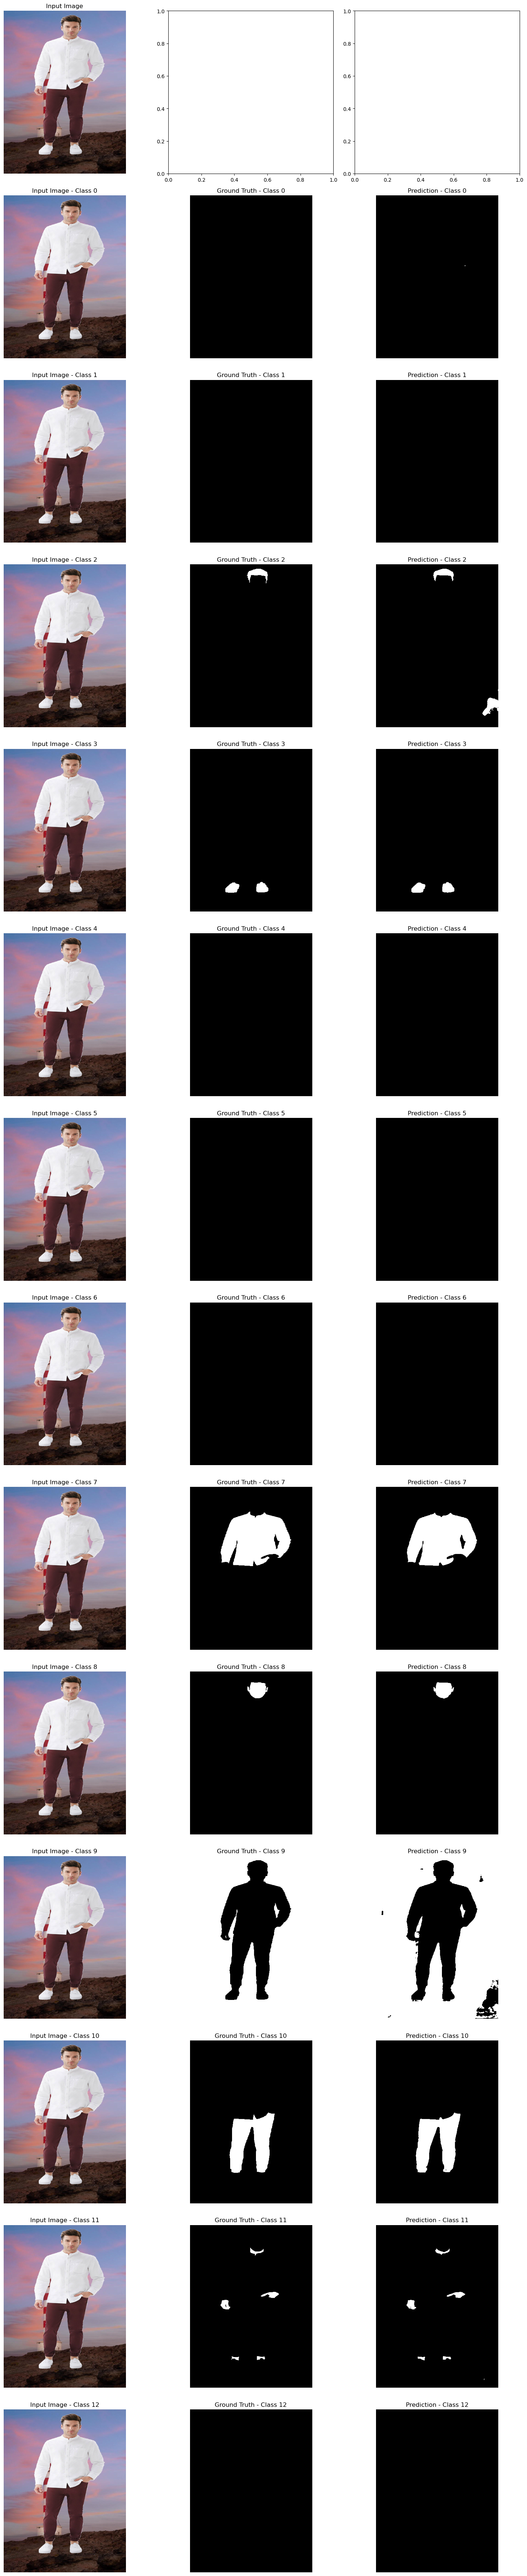

In [48]:
example_index = 6

# Detach and move tensors to CPU
inputs_detached = inputs.detach().cpu()

# If labels and predictions are already numpy arrays, no need to detach and move to CPU
labels_detached = labels.detach().cpu().numpy()
predictions_detached = predictions.detach().cpu().numpy()

# Convert input tensor to numpy array in range [0, 1]
inputs_np = inputs_detached[example_index].numpy()

# Ensure the input tensor is in the correct range [0, 1]
inputs_np = np.clip(inputs_np, 0, 1)

# Convert the tensor to H x W x C format and then to uint8
inputs_np = np.transpose(inputs_np, (1, 2, 0))  # Convert to H x W x C
# inputs_np = (inputs_np * 255)

# Convert numpy array to PIL image
input_image = T.ToPILImage()(inputs_np)

# Print the maximum values for debugging purposes
# print("Max values:", torch.max(inputs), np.max(labels), np.max(predictions))

# Threshold predictions to be 0 or 1
threshold = 0.95
predictions_np = (predictions_detached >= threshold).astype(np.uint8)

# Select the first image in the batch for labels and predictions
labels_np = labels_detached[example_index]
predictions_np = predictions_np[example_index]

# Plotting function
def plot_images(input_image, ground_truth, predictions):
    num_classes = ground_truth.shape[0]
    fig, axes = plt.subplots(num_classes + 1, 3, figsize=(15, 5 * (num_classes + 1)))

    # Plot the original input image
    axes[0, 0].imshow(input_image)
    axes[0, 0].set_title("Input Image")
    axes[0, 0].axis("off")

    # Plot the ground truth and prediction for each class
    for i in range(num_classes):
        axes[i + 1, 0].imshow(input_image)
        axes[i + 1, 0].set_title(f"Input Image - Class {i}")
        axes[i + 1, 0].axis("off")

        axes[i + 1, 1].imshow(ground_truth[i, :, :], cmap='gray')
        axes[i + 1, 1].set_title(f"Ground Truth - Class {i}")
        axes[i + 1, 1].axis("off")

        axes[i + 1, 2].imshow(predictions[i, :, :], cmap='gray')
        axes[i + 1, 2].set_title(f"Prediction - Class {i}")
        axes[i + 1, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_images(input_image, labels_np, predictions_np)

In [ ]:
# import torch
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Function to load the model checkpoint
# def load_checkpoint(checkpoint_path, model):
#     print("Loading checkpoint...")
#     checkpoint = torch.load(checkpoint_path)
#     model.load_state_dict(checkpoint["model_state_dict"])
#     return checkpoint["epoch"]

# # Function to plot input image and predictions
# def plot_images(input_image, predictions):
#     num_classes = predictions.shape[0]
#     fig, axes = plt.subplots(1, 2, figsize=(10, 5))

#     # Plot the original input image
#     axes[0].imshow(input_image)
#     axes[0].set_title("Input Image")
#     axes[0].axis("off")

#     # Plot the prediction
#     axes[1].imshow(predictions, cmap='jet', alpha=0.5)
#     axes[1].set_title("Predicted Mask")
#     axes[1].axis("off")

#     plt.tight_layout()
#     plt.show()

# # Load the model and checkpoint
# model = Segmenter(encoder_df, decoder_df, EMBED_DIMENSION, NUM_HEADS, NUM_CLASSES, encoded_spatial_dim=DYN_CONV_CHANNELS ).to(device)

# checkpoint_path = "checkpoints/0.1470_0.1620_epoch_114.pth"
# load_checkpoint(checkpoint_path, model)
# model.eval()

# # Set up the video capture from the computer camera
# cap = cv2.VideoCapture(0)
# transform = T.Compose([
#     T.ToImage(),
#     T.ToDtype(torch.float,scale=True),
#     T.Resize(size=(MAX_IMAGE_SIDE_SIZE, MIN_IMAGE_SIDE_SIZE), interpolation=Image.BICUBIC),
# ])

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Convert the frame to a tensor and make predictions
#     input_tensor = transform(frame).unsqueeze(0)
#     with torch.no_grad():
#         predictions = model(input_tensor)
#         predictions = torch.softmax(predictions, dim=1)
#         # threshold = 0.95
#         # predictions_np = (predictions_detached >= threshold).astype(np.uint8)
#         predictions_np = torch.argmax(predictions, dim=1).squeeze().cpu().numpy()

#     # Convert the predictions to a color map
#     color_map = cv2.applyColorMap(predictions_np.astype(np.uint8) * (255 // model.num_classes), cv2.COLORMAP_JET)
#     overlay = cv2.addWeighted(frame, 0.7, color_map, 0.3, 0)

#     # Display the input frame and the overlay
#     cv2.imshow('Input Frame', frame)
#     cv2.imshow('Prediction Overlay', overlay)

#     # Plot input image and predictions when 'p' is pressed
#     if cv2.waitKey(1) & 0xFF == ord('p'):
#         input_image_np = np.transpose(input_tensor.squeeze().cpu().numpy(), (1, 2, 0))
#         input_image_np = np.clip(input_image_np, 0, 1)
#         plot_images(input_image_np, predictions_np)

#     # Exit when 'q' is pressed
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # Release the capture and close windows
# cap.release()
# cv2.destroyAllWindows()


Loading checkpoint...


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1266: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [ ]:
with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  model_inference        24.00%      13.098ms       100.00%      54.585ms      54.585ms       1.987ms         0.56%     351.731ms     351.731ms             1  
                                     aten::conv2d         0.76%     417.000us        21.11%      11.524ms     114.099us     283.000us         0.08%     117.803ms       1.166ms           101  
                                aten::c

In [ ]:
# # Initialize Weights & Biases
# wandb.init(project="segmenter")

# # Assuming CombinedLoss, model, optimizer, train_loader, test_loader, device are defined
# criterion = CombinedLoss()

# def plot_gradients_boxplot(gradients, epoch):
#     # Separate and sort gradients by layer name
#     sorted_gradients = dict(sorted(gradients.items(), key=lambda item: item[0]))

#     def plot_individual_gradients(gradients, title):
#         for name, grad in gradients.items():
#             fig, ax = plt.subplots(figsize=(12, 2))
#             gradient_data = grad.flatten()
            
#             ax.boxplot(gradient_data, vert=False, patch_artist=True)
#             ax.set_title(f'{title} Gradient Distribution at Epoch {epoch} ({name})')
#             ax.set_xlabel('Gradient value')
#             ax.set_ylabel('Layers')
#             plt.show()

#     # Plot each gradient individually
#     plot_individual_gradients(sorted_gradients, "Model")

# def get_gradients(model):
#     gradients = {}
#     for name, param in model.named_parameters():
#         if param.requires_grad:
#             gradients[name] = param.grad.clone().cpu().data.numpy()
#     return gradients

# # Checkpoint loading
# def load_checkpoint(checkpoint_path, model, optimizer):
#     print("Loading checkpoint...")
#     checkpoint = torch.load(checkpoint_path)
#     model.load_state_dict(checkpoint["model_state_dict"])
#     optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
#     return checkpoint["epoch"]

# # Check if a previous checkpoint exists
# start_epoch = 0

# # Overfit one batch
# overfit_batch = next(iter(train_loader))
# inputs, labels = overfit_batch
# inputs = inputs.to(device)
# labels = labels.to(device)

# # Usage in the training loop
# count = 0
# for epoch in range(start_epoch, NUMBER_OF_EPOCHS):
#     model.train()
#     running_loss = 0.0
#     num_batches = 0

#     train_bar = tqdm(range(100), desc=f"Training Epoch {epoch + 1}/{NUMBER_OF_EPOCHS}")
#     # Collect and plot gradients only at epoch 3
#     if count == 15:
#         gradients = get_gradients(model)
#         plot_gradients_boxplot(gradients, epoch)
#     for _ in train_bar:
#         optimizer.zero_grad()

#         outputs = model(inputs)
        
#         loss = criterion(outputs, labels)
#         loss.backward()
        
#         optimizer.step()

#         running_loss += loss.item()
#         num_batches += 1
#         train_bar.set_postfix(loss=loss.item())
#     count += 1
#     average_running_loss = running_loss / num_batches
#     print(f"Overfitting Epoch {epoch + 1}/{NUMBER_OF_EPOCHS}, Loss: {average_running_loss:.4f}")
#     wandb.log({"overfit_loss": average_running_loss}, step=epoch)

# print("Overfitting complete.")
